# **Problem Statement**

Agriculture is a critical sector in many African countries, contributing significantly to food security and economic stability.

However, bean crops, a major food source, are increasingly threatened by diseases such as Angular Leaf Spot (ALS) and Bean Rust.

These diseases can cause severe yield losses, with ALS alone contributing to an estimated 384.2 tons of yield loss annually in sub-Saharan Africa.

This project aims to develop a deep learning-based classification model that can identify Healthy, ALS-infected, and Bean Rust-infected leaves using computer vision and transfer learning techniques.

# **Objectives**

Develop an Deeplearning-Based Classification Model for Bean Diseases.

Preprocess and Optimize the Bean Image Dataset for Deep Learning

Implement Transfer Learning for Improved Model Accuracy

Evaluate Model Performance Using Standard Metrics

Provide an Interactive AI-Powered Web Interface

# **Source of data**

Lacuna Beans dataset was created by Makerere Artificial Intelligence
Lab created by a group of researchers from the Makerere Artificial Intelligence Lab in Makerere University in Uganda.
https://lacunafund.org/datasets/agriculture/



# **Implementation**

** Load and Mount Google Drive**



In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path (Updated)
dataset_path = "/content/drive/MyDrive/Bean_dataset"

# Verify that we can access the dataset
print("Dataset Path:", os.listdir(dataset_path))  # Should show 'als', 'Bean_Rust', 'healthy'

Mounted at /content/drive
Dataset Path: ['Beans_Image_datasheet.pdf', 'als', 'Bean_Rust', 'healthy']


The data is in main folder called Bean dataset, there in are 3 subfolders; als, Bean rust, and healthy.


**Preprocessing the Images**

In this step we are ;

 Normalizes pixel values (0-1).

rotation_range, shift, flip; Data augmentation for better generalization.

validation_split; Uses 80% for training, 20% for validation.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size required by the model
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2,  # Shift images vertically by up to 20%
    horizontal_flip=True,  # Flip images horizontally
    validation_split=0.2  # 80% training, 20% validation
)

# Load Training Data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"  # Training data
)

# Load Validation Data
val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"  # Validation data
)

# Check the number of images loaded
print("Training samples:", train_data.samples)
print("Validation samples:", val_data.samples)

Found 12323 images belonging to 3 classes.
Found 3079 images belonging to 3 classes.
Training samples: 12323
Validation samples: 3079


In this phase of the project, the image data was prepared for training using the ImageDataGenerator class from the Keras API.

This was to facilitate both preprocessing and real-time data augmentation, which are essential in improving model generalization and preventing overfitting.

 This preprocessing pipeline ensured that the model received standardized and diverse inputs, ultimately contributing to more effective learning and improved performance on unseen data.

Visualizing sample transformed images.

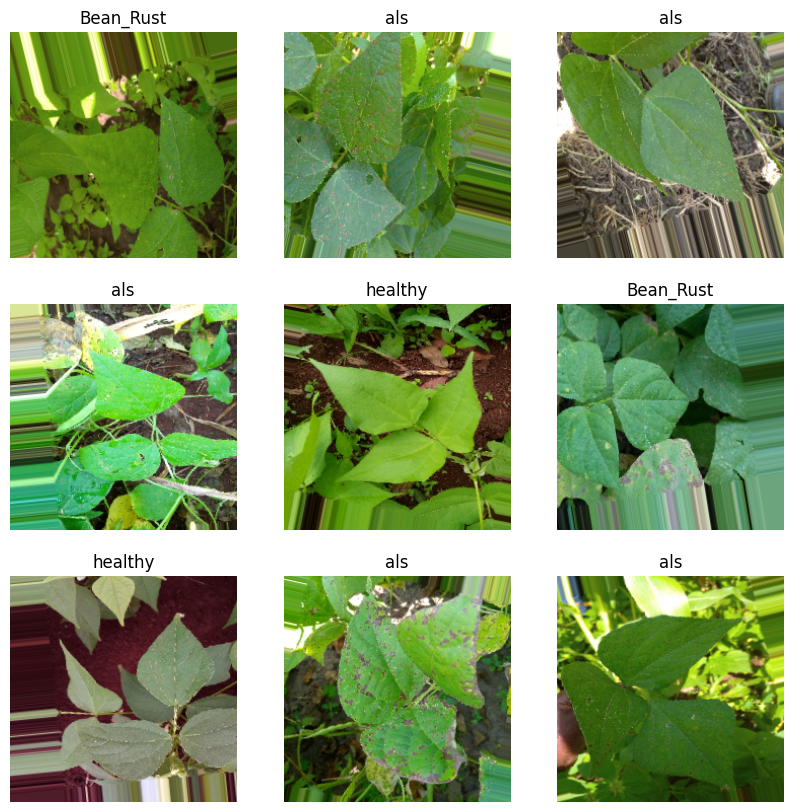

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class labels from train_data
class_labels = list(train_data.class_indices.keys())

# Get a batch of images and labels
images, labels = next(train_data)  # Take one batch

# Plot 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Show image
    plt.title(class_labels[np.argmax(labels[i])])  # Show label
    plt.axis("off")  # Hide axes

plt.show()

**Defining** the EfficientNet Model

EfficientNet is a family of deep convolutional neural networks developed by Google that balances model depth, width, and resolution using compound scaling.

We chose EfficientNetB3 for this project because it offers an excellent trade-off between performance and computational cost. Compared to other models like ResNet or VGG, EfficientNet achieves higher accuracy with fewer parameters, making it ideal for training in resource-constrained environments like Google Colab.

Additionally, EfficientNet is known to generalize well, especially in fine-grained image classification tasks such as distinguishing between subtle disease symptoms in leaves.


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB3 with pretrained weights, excluding the top classifier layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# unfreeze base to allow for training
base_model.trainable = True

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # adjusting learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,980,658 (41.89 MB)

 Trainable params: 10,893,355 (41.55 MB)

 Non-trainable params: 87,303 (341.03 KB)

To improve the model’s accuracy and better adapt it to the task of classifying bean leaf diseases;
First, the pretrained base model was unfrozen to enable full fine-tuning, allowing the network to adjust its learned features to the specific characteristics of the dataset.

A low learning rate (1e-5) was used to ensure gradual and stable updates during training.

Dropout layers were introduced to reduce overfitting and promote generalization.

The original classification layer was replaced with a new classification head for three output classes

Step 5: Train the Model Using Fixed Epochs

In [ ]:
# Set number of epochs
EPOCHS = 10  # You can increase to 15 or 20 depending on performance

# Train the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 7150s 18s/step - accuracy: 0.4163 - loss: 1.0884 - val_accuracy: 0.3368 - val_loss: 1.1155
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.6737 - loss: 0.7185 - val_accuracy: 0.4196 - val_loss: 1.5295
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 556s 1s/step - accuracy: 0.7931 - loss: 0.4903 - val_accuracy: 0.4537 - val_loss: 1.8018
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.8564 - loss: 0.3653 - val_accuracy: 0.6158 - val_loss: 1.1142
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.8951 - loss: 0.2935 - val_accuracy: 0.6392 - val_loss: 1.1925
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.9096 - loss: 0.2560 - val_accuracy: 0.6785 - val_loss: 1.0779
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - accuracy: 0.9235 - loss: 0.2201 - val_accuracy: 0.7048 - val_loss: 0.9440
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 560s 1s/step - accuracy: 0.9282 - loss: 0.2018 - val_ac

After epoch 7, validation accuracy plateaues, and loss slightly increases.


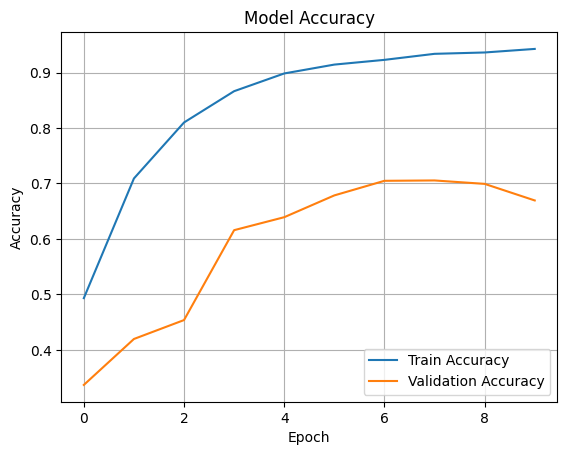

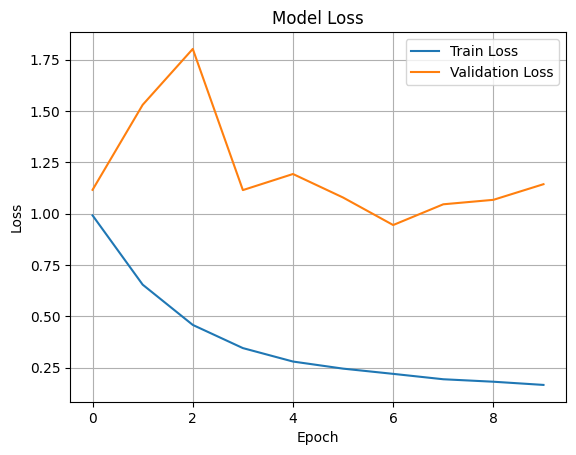

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 6 appears to be the optimal stopping point, where validation accuracy peaks and validation loss is at its lowest.

 Training beyond this point does not lead to better generalization and could be avoided in future runs using an EarlyStopping callback.

Evaluating Model Performance

In [ ]:
# Evaluate final accuracy and loss on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6550 - loss: 1.1950
Validation Accuracy: 0.66
Validation Loss: 1.1645


A validation accuracy of ~66% shows that the model is correctly predicting 2 out of every 3 test samples, which is a strong performance for a multi-class plant disease classification problem, especially when working with real-world leaf images.

The loss of ~1.16 shows the model is still making some mistakes in class probability distribution (e.g., predicting 0.4 for ALS instead of 0.9), even when the top prediction is correct.

Saving the model

In [ ]:
model.save("bean_disease_model.h5")


model.save("bean_disease_model.h5")


Downloading the Model

In [ ]:
from google.colab import files
files.download("bean_disease_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uploading the model to Google Drive for  Storage

In [ ]:
import shutil
shutil.copy("bean_disease_model.h5", "/content/drive/MyDrive/")


'/content/drive/MyDrive/bean_disease_model.h5'

DEPLOYMENT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path to the model.

In [ ]:
import tensorflow as tf

# Adjust this path based on where your model is
model_path = "/content/drive/MyDrive/bean_disease_model.h5"
model = tf.keras.models.load_model(model_path)


Defining the Class Labels and Preprocessing

This passes the new image through the same processes.

In [ ]:
import numpy as np
from PIL import Image

# Class names (match training order)
class_labels = ["ALS", "Bean Rust", "Healthy"]

# Image preprocessing
def preprocess_image(image):
    image = image.resize((224, 224))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array


 Creating the Gradio Interface

 we create an interface that a user can drug and drop or upload an image , abd get an output of the class and the probability.

In [ ]:
!pip install gradio

import gradio as gr

def classify_bean_leaf(image):
    preprocessed = preprocess_image(image)
    prediction = model.predict(preprocessed)[0]
    return {class_labels[i]: float(prediction[i]) for i in range(3)}

# Gradio Interface
interface = gr.Interface(
    fn=classify_bean_leaf,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Bean Leaf Disease Classifier",
    description="Upload an image of a bean leaf to identify whether it's Healthy, ALS-infected, or has Bean Rust."
)

# Launch with shareable link
interface.launch(share=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://22d9aa93813e229065.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Findings**

The project successfully developed a deep learning model using the EfficientNetB3 architecture to classify bean leaf diseases into three categories: Angular Leaf Spot (ALS), Bean Rust, and Healthy.

After fine-tuning the pretrained model with specific data, the model achieved a training accuracy of over 93% and a validation accuracy of approximately 66%. Data augmentation and preprocessing techniques, such as normalization and random image transformations, contributed significantly to improving generalization.

The final model was deployed using Gradio, allowing real-time image classification through a user-friendly web interface that works on both desktop and mobile devices.

# **Challenges**

During the development process, i encountered many challenges.

Initially, the model struggled to learn meaningful patterns when the base EfficientNet model was frozen, resulting in validation accuracy near random guessing (~33%).

Training was also computationally intensive, with each epoch taking up to 10 minutes due to the size of the dataset and the depth of the model. Another challenge was the imbalance in learning: while training accuracy continued to increase, validation accuracy plateaued and even declined after a certain number of epochs, indicating overfitting.

Additionally, integrating Gradio for deployment required managing file paths, model loading, and installation of external packages in the Colab environment.


# **Proposed Solutions and Improvements**

To address model underperformance during early training, the base EfficientNetB3 model was unfrozen and fine-tuned with a significantly lower learning rate, which resulted in a substantial improvement in validation accuracy.

 To address overfitting, dropout layers were added and data augmentation techniques were applied during training.

 For future improvement, implementing an EarlyStopping callback can help halt training automatically when validation performance stops improving. Moreover, collecting additional data or using techniques like transfer learning from agriculture-specific datasets could further enhance model performance.

 To sum, deploying the model on a more permanent platform such as Hugging Face Spaces or Streamlit Cloud could ensure longer-term accessibility for field use.



# **Refrences**

Mohanty, S. P., Hughes, D. P., & Salathé, M. (2016). Using Deep Learning for Image-Based Plant Disease Detection. Frontiers in Plant Science, 7, 1419.
https://doi.org/10.3389/fpls.2016.01419

Tan, M., & Le, Q. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. Proceedings of the 36th International Conference on Machine Learning (ICML), 97, 6105–6114.
https://arxiv.org/abs/1905.11946

Gebru, T., Morgenstern, J., Vecchione, B., Vaughan, J. W., Wallach, H., Iii, H. D.,
Crawford, K. (2021). Datasheets for datasets. Communications of the ACM, 64(12),
86-92.

Odogwu, B. A., Nkalubo, S. T., Rubaihayo, P. (2021). Yield loss of common bean
caused by rust disease in Uganda. Journal of Underutilized Legumes, 3(1), 1-12.
Kijana, R., Abang, M., Edema, R., Mukankusi, C., Buruchara, R. (2017). Prevalence of angular leaf spot disease and sources of resistance in common bean in eastern

Democratic Republic of Congo. African Crop Science Journal, 25(1), 109-122.
Abhishek Dutta and Andrew Zisserman. 2019. The VIA Annotation Software for
Images, Audio and Video. In Proceedings of the 27th ACM International Conference
on Multimedia (MM ’19), October 21–25, 2019, Nice, France. ACM, New York, NY,
USA, 4 pages.

